In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

# Add parent directory to path.
from pathlib import Path
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413
fdir = Path(os.path.abspath('')).resolve() # Directory of current file.
path = fdir/'..'
if path not in sys.path:
    sys.path.append(str(path))

# Complete imports.
import numpy as np
import makassar_ml as ml
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [2]:
# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    print(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


In [3]:
strategy = tf.distribute.get_strategy()

In [24]:
# # Augment the input image.
# image_augmentation = tf.keras.Sequential([
#     keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=image_shape),
#     # keras.layers.experimental.preprocessing.RandomRotation(0.2),
# ])

def image_augmentation(image: tf.Tensor, size: tuple[int,int] = None):
    if size is not None:
        dtype = image.dtype # Preserve original data type for casting after resize operation.
        image = tf.image.resize(image, size=size)
        image = tf.cast(image, dtype)
    # image = keras.layers.experimental.preprocessing.Resizing(200,200)(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.cast(image, dtype=tf.float32) / tf.constant(256, dtype=tf.float32) # Rescale.
    # image = tfa.image.rotate(image, tf.random.normal(shape=[])*np.pi/180., interpolation='bilinear')
    return image

In [25]:

image_size = (72,72)
with strategy.scope():
    (ds_train, ds_val, ds_test), info = tfds.load(
        name='plant_village',
        split=['train[0%:70%]', 'train[70%:90%]', 'train[90%:]'],
        as_supervised=True,
        with_info=True,
        shuffle_files=True,
    )
    label_names = info.features['label'].names

    # Augment the training images.
    ds_train = ds_train.map(lambda x, y: (image_augmentation(x, size=image_size), y))
    ds_val = ds_val.map(lambda x, y: (image_augmentation(x, size=image_size), y))

    # builder = tfds.builder('plant_village')
    # label_names = builder.info.features['label'].names
    # builder.download_and_prepare()
    # ds = builder.as_dataset(split='train', as_supervised=True)

(72, 72, 3) 4 Blueberry___healthy
(72, 72, 3) 24 Soybean___healthy
(72, 72, 3) 15 Orange___Haunglongbing_(Citrus_greening)
(72, 72, 3) 37 Tomato___Tomato_Yellow_Leaf_Curl_Virus


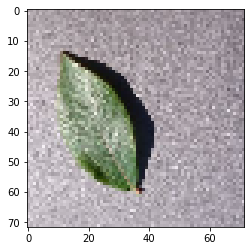

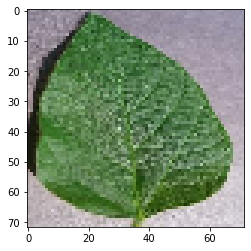

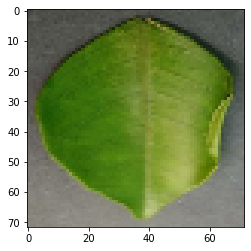

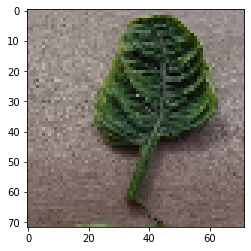

In [29]:
for example in ds_train.take(4):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example[0]
    label = example[1].numpy()
    print(image.shape, label, label_names[label])
    plt.figure()
    plt.imshow(image)

In [63]:
with strategy.scope():
    model = ml.models.transformer_tl_vision.build_model(
        image_shape = (256,256,3),
        image_backbone_name = 'ResNet50', # Must be within `keras.applications`
        image_encoder_dim = 32,
        n_class = len(label_names),
        dropout = 0.1,
        n_image_encoders = 6,
        n_image_heads = 8,
        image_ff_dim = 256,
        fc_units = [128],
    )
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_10  (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add_10 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 32)          65568     
_________________________________________________________________
reshape_5 (Reshape)          (None, 64, 32)            0   

In [64]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
history = model.fit(ds_train.batch(128).prefetch(1), epochs=3, validation_data=ds_val.batch(128).prefetch(1), verbose=1)

Epoch 1/3
297/297 [==============================] - 128s 406ms/step - loss: 2.2490 - accuracy: 0.4476 - val_loss: 0.4251 - val_accuracy: 0.8734
Epoch 2/3
297/297 [==============================] - 119s 401ms/step - loss: 0.3602 - accuracy: 0.8911 - val_loss: 0.2171 - val_accuracy: 0.9330
Epoch 3/3
297/297 [==============================] - 119s 401ms/step - loss: 0.1940 - accuracy: 0.9387 - val_loss: 0.1647 - val_accuracy: 0.9469


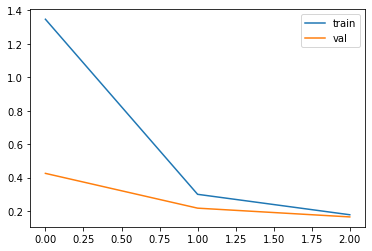

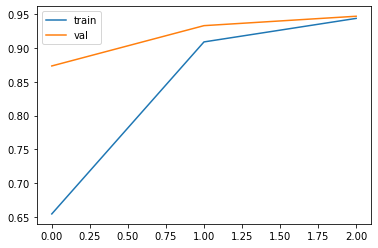

In [65]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()

In [60]:
def build_model(
    image_shape: tuple,
    image_backbone_name: str, # Must be within `keras.applications`
    n_class: int,
    fc_units: list[int] = [],
    ):
    # Ensure both lower and normal case spellings exist for method retrieval.
    assert hasattr(keras.applications, image_backbone_name.lower())
    assert hasattr(keras.applications, image_backbone_name)

    # Image feature extraction network.
    # Pre-trained on ImageNet dataset.
    image_backbone_net = getattr(keras.applications, image_backbone_name)(
        weights='imagenet',
        input_shape=image_shape,
        pooling=None,
        include_top=False,
    )
    image_backbone_net.trainable = False # Freeze the base model so that it will not be updated during training

    # Image input branch.
    inp_image = keras.Input(shape=image_shape)

    # Augment the input image.
    data_augmentation = tf.keras.Sequential([
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=image_shape),
        # keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ])
    x_image = data_augmentation(inp_image)

    # Preprocess image input.
    x_image = getattr(keras.applications, image_backbone_name.lower()).preprocess_input(x_image)
    # Run preprocessed image through backbone image feature extraction network.
    x_image = image_backbone_net(x_image, training=False)
    # x_image = keras.layers.GlobalAveragePooling2D(data_format='channels_last')(x_image)
    # # Project backbone output into dimension necessary for encoder layer.
    # # Reduces channel dimension of image activation map so that it matches that of the encoder.
    # Shape is (batch,w,h,image_encoder_dim)
    x_image = keras.layers.Conv2D(filters=1024, kernel_size=(1,1))(x_image)
    # # # Squeeze feature map dimensions to (batch,w*h,image_encoder_dim)
    # # x_image = keras.layers.Reshape(target_shape=(-1,x_image.shape[-1]))(x_image)
    # # # Create learned positional embedding and add to feature map encoding.
    # # num_feature_maps = x_image.shape[1]
    # # pos = tf.range(
    # #     start=0,
    # #     limit=num_feature_maps,
    # #     delta=1,
    # # )
    # # x_image_pos = keras.layers.Embedding(
    # #     input_dim=num_feature_maps,
    # #     output_dim=image_encoder_dim,
    # # )(pos)
    # # x_image = x_image + x_image_pos
    # # # Pass image feature maps through encoders.
    # # for _ in range(n_image_encoders):
    # #     x_image = TransformerEncoderLayer(
    # #         model_dim=image_encoder_dim,
    # #         key_dim=None,
    # #         n_heads=n_image_heads,
    # #         ff_dim=image_ff_dim,
    # #         value_dim=None,
    # #         dropout=dropout,
    # #         norm_type='layer',
    # #     )(x_image)

    # Flatten to (batch,num_feature_maps*image_encoder_dim)
    x_image = keras.layers.Flatten(data_format='channels_last')(x_image)

    # Add intermediate dense layers with ReLU activation.
    for units in fc_units:
        x_image = keras.layers.Dense(units=units, activation='relu')(x_image)

    # Classifier on the end.
    x_image = keras.layers.Dense(units=n_class, activation='softmax')(x_image)

    return keras.models.Model(inputs=inp_image, outputs=x_image)


with strategy.scope():
    model_notransformer = build_model(
        image_shape = (256,256,3),
        image_backbone_name = 'ResNet50', # Must be within `keras.applications`
        n_class = len(label_names),
        fc_units = [128],
    )
model_notransformer.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_11 (Sequential)   (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_9 ( (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add_9 (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 1024)        2098176   
_________________________________________________________________
flatten_7 (Flatten)          (None, 65536)             0   

In [61]:
model_notransformer.compile(
    optimizer=keras.optimizers.Adam(lr=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
history_notransformer = model_notransformer.fit(ds_train.batch(128), epochs=3, validation_data=ds_val.batch(128), verbose=1)

Epoch 1/3
297/297 [==============================] - 119s 391ms/step - loss: 0.9729 - accuracy: 0.7610 - val_loss: 0.1489 - val_accuracy: 0.9528
Epoch 2/3
297/297 [==============================] - 115s 388ms/step - loss: 0.1072 - accuracy: 0.9662 - val_loss: 0.1059 - val_accuracy: 0.9678
Epoch 3/3
297/297 [==============================] - 115s 388ms/step - loss: 0.0661 - accuracy: 0.9782 - val_loss: 0.1069 - val_accuracy: 0.9683


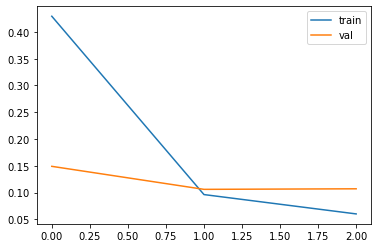

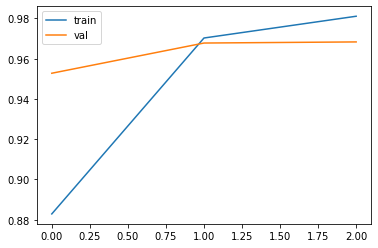

In [62]:
plt.figure()
plt.plot(history_notransformer.history['loss'], label='train')
plt.plot(history_notransformer.history['val_loss'], label='val')
plt.legend()
plt.figure()
plt.plot(history_notransformer.history['accuracy'], label='train')
plt.plot(history_notransformer.history['val_accuracy'], label='val')
plt.legend()

In [37]:
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images: tf.Tensor):
        # Get patches from the original image.
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # Reshape while preserving batch dimension.
        patches = keras.layers.Reshape(
            target_shape=(-1,patches.shape[-1])
        )(patches)
        return patches

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'patch_size': self.patch_size,
        })
        return config


class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches: int, projection_dim: int):
        super().__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim

        # Create layers.
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches,
            output_dim=projection_dim,
        )

        # Pre-create position embedding projection since it doesn't depend on the input.
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, patch):
        encoded = self.projection(patch) + self.position_embedding(self.positions)
        return encoded

    def get_config(self) -> dict:
        """Retreive custom layer configuration for future loading.

        Returns:
            dict: Configuration dictionary.
        """
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection_dim': self.projection_dim,
        })
        return config


def build_vit(
    image_shape: tuple,
    patch_size: int,
    num_patches: int,
    image_encoder_dim: int,
    n_class: int,
    n_image_encoders: int = 3,
    n_image_heads: int = 8,
    image_ff_dim: int = 2048,
    dropout: float = 0.0,
    fc_units: list[int] = [],
    ):
    inp_image = keras.Input(shape=image_shape)
    # Create patches.
    x = Patches(patch_size)(inp_image)
    # print(f"patches {x.shape=}")
    # print(f"{num_patches=}")
    # Encode patches.
    x = PatchEncoder(num_patches, image_encoder_dim)(x)
    # print(f"encoder {x.shape=}")

    # Pass image feature maps through encoders.
    for _ in range(n_image_encoders):
        x = ml.layers.TransformerEncoderLayer(
            model_dim=image_encoder_dim,
            key_dim=None,
            n_heads=n_image_heads,
            ff_dim=image_ff_dim,
            value_dim=None,
            dropout=dropout,
            norm_type='layer',
        )(x)

    # Flatten to (batch,num_feature_maps*image_encoder_dim)
    x = keras.layers.Flatten(data_format='channels_last')(x)

    # Add intermediate dense layers with ReLU activation.
    for units in fc_units:
        x = keras.layers.Dense(units=units, activation='relu')(x)

    # Classifier on the end.
    x = keras.layers.Dense(units=n_class, activation='softmax')(x)

    return keras.models.Model(inputs=inp_image, outputs=x)


patch_size = 6

model_vit = ml.models.vit.ViT(
    image_shape = (image_size[0],image_size[1],3),
    patch_size = patch_size,
    num_patches = (image_size[0]//patch_size)**2,
    embed_dim = 32,
    n_class = len(label_names),
    dropout = 0.1,
    n_encoders = 3,
    n_heads = 8,
    ff_dim = 256,
    fc_units = [128],
    include_top = True,
)
model_vit.summary()

model_vit.compile(
    optimizer=keras.optimizers.Adam(lr=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
history_vit = model_vit.fit(
    ds_train.batch(128).prefetch(1),
    validation_data=ds_val.batch(128).prefetch(1),
    epochs=10, 
    verbose=1,
)


# for batch_x, batch_y in ds_train.batch(128).take(1):
#     patches = Patches(patch_size)(batch_x)
#     print(f"{patches.shape=}")

    # n = int(np.sqrt(patches.shape[1]))
    # print(f"patches per image {patches.shape[1]=}")
    # print(f"elements per patch {patches.shape[-1]=}")
    # plt.figure(figsize=(4, 4))
    # for i, patch in enumerate(patches[0]):
    #     ax = plt.subplot(n, n, i + 1)
    #     patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    #     plt.imshow(patch_img.numpy().astype("uint8"))
    #     plt.axis("off")

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 72, 72, 3)]       0         
_________________________________________________________________
patches_13 (Patches)         (None, 144, 108)          0         
_________________________________________________________________
patch_encoder_13 (PatchEncod (None, 144, 32)           8096      
_________________________________________________________________
transformer_encoder_layer_39 (None, 144, 32)           21024     
_________________________________________________________________
transformer_encoder_layer_40 (None, 144, 32)           21024     
_________________________________________________________________
transformer_encoder_layer_41 (None, 144, 32)           21024     
_________________________________________________________________
flatten_12 (Flatten)         (None, 4608)              0  

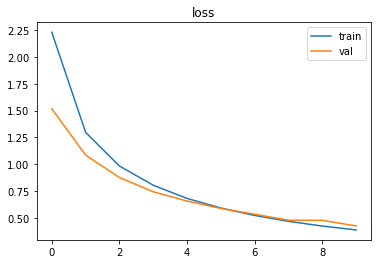

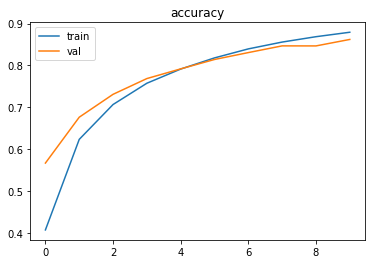

In [36]:
plt.figure()
plt.title('loss')
plt.plot(history_vit.history['loss'], label='train')
plt.plot(history_vit.history['val_loss'], label='val')
plt.legend()
plt.figure()
plt.title('accuracy')
plt.plot(history_vit.history['accuracy'], label='train')
plt.plot(history_vit.history['val_accuracy'], label='val')
plt.legend()

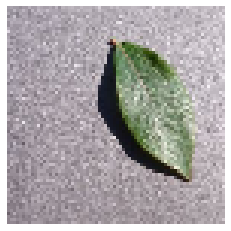

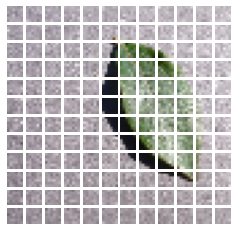

In [57]:
# Show example of image patches.
for batch_x, batch_y in ds_train.batch(1).take(1):

    # Show the original image.
    plt.figure(figsize=(4, 4))
    plt.imshow(batch_x[0])
    plt.axis("off")

    # Display patches.
    patches = ml.models.vit.Patches(patch_size)(batch_x)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(4, 4))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        # plt.imshow(patch_img.numpy().astype("uint8"))
        plt.imshow(patch_img)
        plt.axis("off")

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 24, 5)]      0                                            
__________________________________________________________________________________________________
time2_vec_13 (Time2Vec)         (None, 24, 160)      4512        input_41[0][0]                   
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 24, 165)      0           input_41[0][0]                   
                                                                 time2_vec_13[0][0]               
__________________________________________________________________________________________________
transformer_encoder_layer_93 (T (None, 24, 165)      191806      concatenate_14[0][0]      

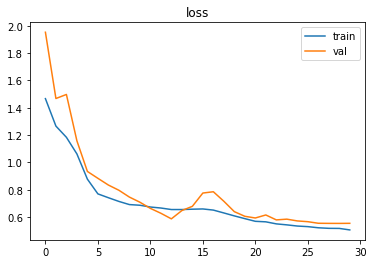

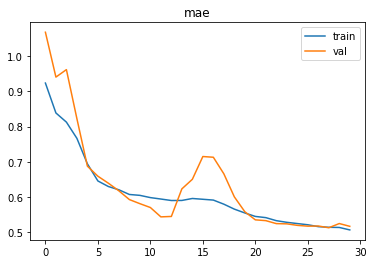

In [51]:
in_seq_len = 24
out_seq_len = 1
shift = 1
split = [0.7,0.2,0.1]
# in_feat = ['DEWP']
in_feat = ['TEMP','PRES','Iws','Is','Ir']
out_feat = ['DEWP']
n_in_feat = len(in_feat)
n_out_feat = len(out_feat)
batch_size = 128

beijing_ds_train, beijing_ds_val, beijing_ds_test = ml.datasets.beijingpm25.load_beijingpm25_ds(
    path=Path("~/research/makassar/datasets/beijing_pm25").expanduser(),
    in_feat=in_feat,
    out_feat=out_feat,
    in_seq_len=in_seq_len,
    out_seq_len=out_seq_len,
    shift=shift,
    split=split,
    shuffle=False,
    batch_size=batch_size,
)

model_fot = ml.models.fot.FoT(
    in_seq_len=in_seq_len,
    in_feat=n_in_feat,
    out_feat=n_out_feat,
    embed_dim=32,
    n_heads=8,
    ff_dim=256,
    dropout=0.1,
    n_encoders=3,
    include_top=True,
)
model_fot.summary()

model_fot.compile(
    optimizer=keras.optimizers.Adam(lr=1e-4),
    loss='mse',
    metrics=['mae'],
)
history_fot = model_fot.fit(
    beijing_ds_train,
    validation_data=beijing_ds_val,
    epochs=30,
    verbose=1,
)

plt.figure()
plt.title('loss')
plt.plot(history_fot.history['loss'], label='train')
plt.plot(history_fot.history['val_loss'], label='val')
plt.legend()
plt.figure()
plt.title('mae')
plt.plot(history_fot.history['mae'], label='train')
plt.plot(history_fot.history['val_mae'], label='val')
plt.legend()

In [41]:
# BUILD NEW MODEL WITH ViT AND FORECAST.

def ViFoT(
    image_shape: tuple,
    patch_size: int,
    num_patches: int,
    seq_in_seq_len: int,
    seq_in_feat: int,
    seq_out_feat: int,
    image_embed_dim: int,
    seq_embed_dim: int,
    n_class: int,
    image_n_encoders: int = 3,
    seq_n_encoders: int = 3,
    image_n_heads: int = 8,
    seq_n_heads: int = 8,
    image_ff_dim: int = 2048,
    seq_ff_dim: int = 2048,
    dropout: float = 0.0,
    image_fc_units: list[int] = [],
    ):

    ###
    # Image Branch.
    ###

    # Input tensor.
    inp_image = keras.Input(shape=image_shape)
    # Vision Transformer for image feature extraction.
    x_image = ml.models.vit.ViT(
        image_shape=image_shape,
        patch_size=patch_size,
        num_patches=num_patches,
        embed_dim=image_embed_dim,
        n_class=n_class,
        n_encoders=image_n_encoders,
        n_heads=image_n_heads,
        ff_dim=image_ff_dim,
        dropout=dropout,
        fc_units=image_fc_units,
        include_top=False,
    )(inp_image)

    ###
    # Sequence Branch.
    ###
    inp_seq = keras.Input(shape=(seq_in_seq_len, seq_in_feat))
    x_seq = ml.models.fot.FoT(
        in_seq_len=seq_in_seq_len,
        in_feat=seq_in_feat,
        embed_dim=seq_embed_dim,
        out_feat=seq_out_feat,
        n_heads=seq_n_heads,
        key_dim=None,
        value_dim=None,
        ff_dim=seq_ff_dim,
        dropout=dropout,
        n_encoders=seq_n_encoders,
        include_top=False,
    )(inp_seq)

    ###
    # Combine results from all branches.
    ###
    # Flatten to ensure tensors can be concatenated.
    x_image = keras.layers.Flatten(data_format='channels_last')(x_image)
    x_seq = keras.layers.Flatten(data_format='channels_last')(x_seq)
    # Concatenate them.
    x = keras.layers.Concatenate(axis=-1)([x_image, x_seq])


    return keras.Model(inputs=[inp_image, inp_seq], outputs=[x])


temp = ViFoT(
    image_shape=(image_size[0],image_size[1],3),
    patch_size=patch_size,
    num_patches=(image_size[0]//patch_size)**2,
    seq_in_seq_len=24,
    seq_in_feat=5,
    seq_out_feat=1,
    image_embed_dim=32,
    seq_embed_dim=32,
    n_class=len(label_names),
    image_n_encoders=3,
    seq_n_encoders=3,
    image_n_heads=8,
    seq_n_heads=8,
    image_ff_dim=256,
    seq_ff_dim=256,
    dropout=0.1,
)
temp.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 72, 72, 3)]  0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 24, 5)]      0                                            
__________________________________________________________________________________________________
model_24 (Functional)           (None, 144, 32)      71168       input_28[0][0]                   
__________________________________________________________________________________________________
model_25 (Functional)           (None, 24, 165)      579930      input_30[0][0]                   
___________________________________________________________________________________________